<a href="https://colab.research.google.com/github/tovfer17/mastersproject/blob/master/multicommodityflowproblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Code for Multicommodity Problem**

In [2]:
!pip install networkx

In [3]:
!pip install xlrd


In [1]:
!pip install -i https://pypi.gurobi.com gurobipy

Looking in indexes: https://pypi.gurobi.com
     |████████████████████████████████| 11.1MB 16.8MB/s 


Imports and Initializations

In [15]:

import networkx as netx  # nice (di-)graph Python package
import matplotlib.pyplot as plt
import numpy as np
import math
import gurobipy as gp
from gurobipy import GRB
import xlrd

vertices = []
vertices_no = 0
weight = []
graph = []
leavingnode=[]
comingnode=[]
comm=[]
tran=[]
allCost={}
demand ={}
start=[]
cnode=[]
nodes=[]
G = netx.DiGraph()


loc=("/networkflow2c.xls")

wb = xlrd.open_workbook(loc)
vertex=wb.sheet_by_index(0)
capacities=wb.sheet_by_index(1)
commodities=wb.sheet_by_index(2)
cost=wb.sheet_by_index(3)
inflow=wb.sheet_by_index(4)

################ adding vertex from excel ######################

In [16]:
def add_vertex(v):
    global graph
    global vertices_no
    global vertices
    if v in vertices:
        print("Vertex ", v, " already exists")
    else:
        vertices_no = vertices_no + 1
        vertices.append(v)
        if vertices_no > 1:
            for vertex in graph:
                vertex.append(0)
        temp = []
        for i in range(vertices_no):
            temp.append(0)
        graph.append(temp)

################ adding edge from excel ######################

In [17]:

def add_edge(v1, v2, e):
    global graph
    global vertices_no
    global vertices
    # Check if vertex v1 is a valid vertex
    if v1 not in vertices:
        print("Vertex ", v1, " does not exist.")
    # Check if vertex v1 is a valid vertex
    elif v2 not in vertices:
        print("Vertex ", v2, " does not exist.")
    # Since this code is not restricted to a directed or
    # an undirected graph, an edge between v1 v2 does not
    # imply that an edge exists between v2 and v1
    else:
        index1 = vertices.index(v1)
        index2 = vertices.index(v2)
        graph[index1][index2] = e

################ print the pair of nodes and edgeweight ######################

In [18]:

def print_graph():
    global graph
    global vertices_no
    for i in range(vertices_no):
        for j in range(vertices_no):
            if graph[i][j] != 0:
                print(vertices[i], " -> ", vertices[j], \
                      " edge weight: ", graph[i][j])
                #print vertices


################ draw the newtworkxgraph ######################

In [19]:
def draw_graph():
    global graph
    global vertices_no
    global vertices
    global weight

    for i in range(vertices_no):
        for j in range(vertices_no):
            if graph[i][j] != 0:
                weight=(graph[i][j])
                G.add_edge(vertices[i], vertices[j], weight=weight)


    epos = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]

    pos = netx.spring_layout(G, k=150, seed=200)  # positions for all nodes - seed for reproducibility
    # nodes
    netx.draw_networkx_nodes(G, pos)
    # edges
    labels = netx.get_edge_attributes(G, 'weight')
    netx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    netx.draw_networkx_edges(G, pos, edgelist=epos, width=10,edge_color="orange")
    # labels
    netx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    #plt.tight_layout()

    plt.show()
    #plt.savefig("graphp.png")

################ multicommodity######################

In [20]:

def max_flow(test,cost,demands):
    global graph
    global vertices_no
    global vertices
    global weight


    listkeyPair=[]
    for i in range(vertices_no):
        for j in range(vertices_no):
           if graph[i][j] != 0:
                listkeyPair.append((vertices[i], vertices[j]))
    print("This prints out the nodes in the pair: ",listkeyPair)

    listvalueCap=[]
    for i in range(vertices_no):
        for j in range(vertices_no):
            if  graph[i][j] != 0:
                listvalueCap.append((graph[i][j]))
    print("This prints out the capacity of the node pair: ", listvalueCap)

    di,capacity = gp.multidict(dict(zip(listkeyPair, listvalueCap)))
    print("The dictionary after the merge of the pairs of nodes with the capacities:")
    print (capacity)


    listnodes=[]
    #for a in range(1):
    for i in range(vertices_no):
                listnodes.append((test,vertices[i]))
    print("lsit of nodes with each commodity:", listnodes)

    listactualnodes = []
    for i in range(vertices_no):
            listactualnodes.append((vertices[i]))
    print("lsit of actual nodes:", listactualnodes)


    inter_nodes_list = listactualnodes

    # removes the first two nodes from the vertex list because its the source node
    inter_nodes_list.remove(vertices[0])
    inter_nodes_list.remove(vertices[1])
    # removes the two last nodes from the vertex list because they are the sink nodes
    inter_nodes_list.remove(vertices[-1])
    inter_nodes_list.remove(vertices[-2])
    print("inter", inter_nodes_list)

    print("demand",demand)
    print("cost",cost)
    # Create optimization model
    m = gp.Model('netflow')

    # Create variables
    #flow = m.addVars(test,di, obj=cost, name="flow")
    flow = m.addVars(test, di,obj=cost,  name="flow")
    #m.setObjective(flow.prod(cost), GRB.MINIMIZE)

    m.update()

     #Arc-capacity constraints
    for x,y in di:
      m.addConstr(sum(flow[h, x, y] for h in test) <= capacity[x, y], "cap[%s, %s]" % (x, y))

     #Flow-conservation constraints
    # they require that, for each commodity and node, the sum of the flow into the node
    # plus the quantity of external inflow at that node must be equal to the sum of the flow out of the node:
    m.addConstrs(
        (gp.quicksum(flow[h,x,y] for x, y in di.select('*', y)) + demands[h,y]   ==
          gp.quicksum(flow[h, y, k] for y, k in di.select(y, '*'))
          for h in test for y in inter_nodes_list), "node")

    # Compute optimal solutions
    m.optimize()
    print (m.display())

    print("if model fesible it will print a 2 .", m.status)

    # Print solution

    # print solution: optimal value and optimal point
    print('Obj: %g' % m.objVal)
     #print(f"optimal value = {model.objVal:.2f}")
    for v in m.getVars():
       print('%s %g' % (v.varName, v.x))


In [21]:
#################Driver#########################

p = 1
while True:
    try:
        v = vertex.cell_value(p, 0)
        add_vertex(v)
        nodes.append(v)
        print(nodes)
        p = p+1
    except IndexError:
        break

i = 1
while True:
    try:

        l = capacities.cell_value(i, 0)
        c = capacities.cell_value(i, 1)
        cap = capacities.cell_value(i,2)
        add_edge(l,c,cap)
        i = i+1
    except IndexError:
        break

o=1
while True:
    try:
        c = capacities.cell_value(o, 1)
        comingnode.append(c)
        l = capacities.cell_value(o, 0)
        leavingnode.append(l)
        o = o+1
    except IndexError:
        break

eM=1
while True:
    try:
        m = commodities.cell_value(eM, 0)
        comm.append(m)
        eM = eM+1
    except IndexError:
        break





for commo in comm:
    s = 1
    j=3
    print("Commodity:", commo)
    for leave in leavingnode:
        print("leave",leave)
        cnode = capacities.cell_value(s, 1)
        print('coming',cnode)
        allCost[commo,leave,cnode]=cost.cell_value(s,j)
        print("cost:", allCost[commo,leave,cnode])
        s = s+1
    print("this is j:",j)



z = 1
while True:
    try:
        for commo in comm:
           print("Commodity:", commo)
           for ver in nodes:
                   demand[commo,ver]=inflow.cell_value(z,2)
                   print("inflow:", demand[commo,ver])
                   z = z+1
    except IndexError:
        break






['a']
['a', 'b']
['a', 'b', 'c']
['a', 'b', 'c', 'd']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e', 'f']
['a', 'b', 'c', 'd', 'e', 'f', 'g']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'mobile']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'mobile', 'laptop']
Commodity: netflix
leave a
coming d
cost: 1.0
leave d
coming g
cost: 2.0
leave g
coming mobile
cost: 3.0
leave c
coming e
cost: 4.0
leave c
coming f
cost: 5.0
leave f
coming b
cost: 6.0
leave b
coming g
cost: 7.0
leave a
coming e
cost: 8.0
leave f
coming laptop
cost: 4.0
this is j: 3
Commodity: instagram
leave a
coming d
cost: 1.0
leave d
coming g
cost: 2.0
leave g
coming mobile
cost: 3.0
leave c
coming e
cost: 4.0
leave c
coming f
cost: 5.0
leave f
coming b
cost: 6.0
leave b
coming g
cost: 7.0
leave a
coming e
cost: 8.0
leave f
coming laptop
cost: 4.0
this is j: 3
Commodity: netflix
inflow: 0.6696428571428571
inflow: -0.2976190476190476
inflow: 1.7857142857142858
inflow: -1.7857142857142856
inflow: -0.37202380952380953
inflow: -0.4092261904

a  ->  d  edge weight:  130.0
a  ->  e  edge weight:  112.0
b  ->  g  edge weight:  46.0
c  ->  e  edge weight:  120.0
c  ->  f  edge weight:  90.0
d  ->  g  edge weight:  140.0
f  ->  b  edge weight:  50.0
f  ->  laptop  edge weight:  40.0
g  ->  mobile  edge weight:  100.0
Internal representation:  [[0, 0, 0, 130.0, 112.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 46.0, 0, 0], [0, 0, 0, 0, 120.0, 90.0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 140.0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 50.0, 0, 0, 0, 0, 0, 0, 40.0], [0, 0, 0, 0, 0, 0, 0, 100.0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


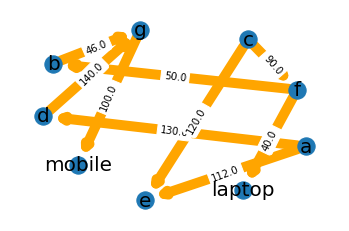

END:
Comm ['netflix', 'instagram']
allCost {('netflix', 'a', 'd'): 1.0, ('netflix', 'd', 'g'): 2.0, ('netflix', 'g', 'mobile'): 3.0, ('netflix', 'c', 'e'): 4.0, ('netflix', 'c', 'f'): 5.0, ('netflix', 'f', 'b'): 6.0, ('netflix', 'b', 'g'): 7.0, ('netflix', 'a', 'e'): 8.0, ('netflix', 'f', 'laptop'): 4.0, ('instagram', 'a', 'd'): 1.0, ('instagram', 'd', 'g'): 2.0, ('instagram', 'g', 'mobile'): 3.0, ('instagram', 'c', 'e'): 4.0, ('instagram', 'c', 'f'): 5.0, ('instagram', 'f', 'b'): 6.0, ('instagram', 'b', 'g'): 7.0, ('instagram', 'a', 'e'): 8.0, ('instagram', 'f', 'laptop'): 4.0}
Demand {('netflix', 'a'): 0.6696428571428571, ('netflix', 'b'): -0.2976190476190476, ('netflix', 'c'): 1.7857142857142858, ('netflix', 'd'): -1.7857142857142856, ('netflix', 'e'): -0.37202380952380953, ('netflix', 'f'): -0.40922619047619047, ('netflix', 'g'): -0.17113095238095238, ('netflix', 'mobile'): -2.008928571428571, ('netflix', 'laptop'): -0.5059523809523809, ('instagram', 'a'): 2.9166666666666665, ('ins

In [22]:
print_graph()
print("Internal representation: ", graph)
draw_graph()

print("END:")
print("Comm",comm)
print("allCost",allCost)
print("Demand",demand)
max_flow(comm, allCost, demand)

